In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras import metrics
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.models import load_model
from sklearn import preprocessing
from keras.models import load_model
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier



Using TensorFlow backend.


In [4]:
# def rnn_auto(layer , size, num_encode_layers, num_decode_layers, embedding, n_step, lr = 3e-6, drop_frac=0.,bidirectional=False, l1_norm = 1e-4,**kwargs):
   """
    Function which builds the reccurrent neural network autoencoder
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    num_encode_layers  : numpy, int
        sets the number of encoding layers in the network
    num_decode_layers : numpy, int
        sets the number of decoding layers in the network
    embedding : numpy, int
        sets the size of the embedding layer
    n_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidirectional : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """
#     # defines the model
#     model = Sequential()

#     # selects if the model is bidirectional
#     if bidirectional:
#         wrapper = Bidirectional
#         # builds the first layer
#         model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
#                             input_shape=(n_step, 1)))
#     else:
#         wrapper = lambda x: x
#         # builds the first layer
#         model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
#                 input_shape=(n_step, 1))))

#     # builds the encoding layers
#     for i in range(1, num_encode_layers):
#         model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

#     # builds the embedding layer
#     if l1_norm == None:
#         # embedding layer without l1 regulariization
#         model.add(Dense(embedding, activation='relu', name='encoding'))
#     else:
#         # embedding layer with l1 regularization
#         model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

#     # builds the repeat vector
#     model.add(RepeatVector(n_step))

#     # builds the decoding layer
#     for i in range(num_decode_layers):
#         model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

#     # builds the time distributed layer to reconstruct the original input
#     model.add(TimeDistributed(Dense(1, activation='linear')))

#     # complies the model
#     model.compile(Adam(lr), loss='mse')

#     # returns the model
#     return model

# # def train_model(model, data_train, data_test, path, epochs, batch_size):

# #     #builds the filename
# #     filepath = path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
# #     # sets the control of checkpoints
# #     checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
# #                                              save_weights_only=True, mode='min', period=1)

# #     # fits the model
# #     model.fit(np.atleast_3d(data1), np.atleast_3d(data2), epochs=250000,
# #           batch_size=1200, validation_data=(np.atleast_3d(data), np.atleast_3d(data)),
# #           callbacks=[tbCallBack, checkpoint])



IndentationError: unexpected indent (<ipython-input-4-ea06e7a3a97d>, line 2)

In [2]:
def create_model( layer = LSTM, size = 256, num_encode_layers = 3 , num_decode_layers = 4, embedding = 32, n_step = 100, lr = 1e-5, drop_frac=0.,bidirectional=True, l1_norm = 1e-4, **kwargs):
    model = Sequential()
    if bidirectional:
        wrapper = Bidirectional
        # builds the first layer
        model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
                            input_shape=(n_step, 1)))
    else:
        wrapper = lambda x: x
        # builds the first layer
        model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
                input_shape=(n_step, 1))))
        
    for i in range(1, num_encode_layers):
        model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

    # builds the embedding layer
    if l1_norm == None:
        # embedding layer without l1 regulariization
        model.add(Dense(embedding, activation='relu', name='encoding'))
    else:
        # embedding layer with l1 regularization
        model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(n_step))

    # builds the decoding layer
    for i in range(num_decode_layers):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model 

In [119]:
model = KerasClassifier(build_fn = create_model, verbose = 0)

In [146]:
num_encode_layers = [1,2,3,4]
num_decode_layers = [1,2,3,4]
embedding = [16,32]
drop_frac = [0., 0.2, 0.5]
epochs = [50,100,150]
batch_size = [10,20,30]

param_grid = dict( batch_size = batch_size, epochs = epochs)

grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv = 5)
grid_result = model.fit(np.atleast_3d(y1), np.atleast_3d(y2))

ValueError: Invalid shape for y: (1000, 100, 1)

In [147]:
grid

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1aa2139d30>,
             iid='warn', n_jobs=-1,
             param_grid={'batch_size': [10, 20, 30], 'epochs': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [4]:
iList = [10,100,1000,10000,100000,1000000]
x = np.linspace(0,1,100)
netWork = [8,16,32,64,128,256,512]
eCode = [1,2,3,4,5,10]
dCode = [1,2,3,4,5,10]
eBed = [16,32]
loss = 999999999
f_y1 = []
f_y2 = []
f_fit = []
information = []
for i in iList:
    y1 = []
    y2 = []
    a = []
    b = []
    c = []
    d = []
    e = []
    f = []
    z1 = np.random.uniform(0,12)
    z2 = np.random.uniform(0,12)
    z3 = np.random.uniform(0,12)
    z4 = np.random.uniform(0,12)
    z5 = np.random.uniform(0,12)
    z6 = np.random.uniform(0,12)
    z7 = np.random.uniform(0,12)
    z8 = np.random.uniform(0,12)
    z9 = np.random.uniform(0,12)
    z10 = np.random.uniform(0,12)
    z11 = np.random.uniform(0,12)
    z12 = np.random.uniform(0,12)
    
    for k in range(i):
        a_ = np.random.normal(8, 1, 1)
        b_ = np.random.normal(7, 2, 1)
        c_ = np.random.normal(6, 3, 1)
        d_ = np.random.normal(5, 4, 1)
        e_ = np.random.normal(4, 5, 1)
        f_ = np.random.normal(3, 7, 1)
        y1_, y2_ = function_gen(x, a_, b_, c_, d_,e_,f_,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12)
        y1.append(y1_)
        y2.append(y2_)
        a.append(a_)
        b.append(b_)
        c.append(c_)
        d.append(d_)
        e.append(e_)
        f.append(f_)
        
    nor_y1 = preprocessing.normalize(y1)
    nor_y2 = preprocessing.normalize(y2)
        
    for j in netWork:
        for l in eCode:
            for m in dCode:
                for n in eBed:
                    auto_test = rnn_auto(LSTM, j, l, m, n, 100)
                    model1 = auto_test.fit(np.atleast_3d(nor_y1), np.atleast_3d(nor_y2), epochs= 100, batch_size=2000)
                    if model1.history['loss'][99] < loss:
                        loss = model1.history['loss'][99]
                        auto_test.save('auto_test')
                        nor_y1_result = auto_test.predict(np.atleast_3d(nor_y1))
                        f_y1 = nor_y1
                        f_y2 = nor_y2
                        f_fit = nor_y1_result
                        information = [i,j,l,m,n]
                    
               
            
           

NameError: name 'function_gen' is not defined

In [129]:
y3 = np.asarray(y1)
y3

array([[ -974.74832884,  -968.96365556,  -963.20139351, ...,
         -511.12253491,  -507.29514552,  -503.48565476],
       [ -757.92186893,  -753.47032716,  -749.03541071, ...,
         -398.25284342,  -395.24731657,  -392.25494334],
       [-1265.73934135, -1258.2713742 , -1250.832189  , ...,
         -666.52033953,  -661.56522354,  -656.63307706],
       ...,
       [-1171.56853534, -1164.58197964, -1157.62386916, ...,
         -618.07397483,  -613.5864069 ,  -609.12186337],
       [-1078.40058881, -1072.00929965, -1065.64306967, ...,
         -567.56395097,  -563.36475678,  -559.18565001],
       [-1114.10504419, -1107.54061698, -1101.00196086, ...,
         -589.6120028 ,  -585.30314573,  -581.0149717 ]])

In [125]:
y4.shape

(1000, 100)

In [126]:
y4 = np.asarray(y2)
y4

array([[ 9.88307848,  9.89663999,  9.91021985, ..., 11.28400275,
        11.29934464, 11.31470488],
       [13.16712736, 13.17226121, 13.17745246, ..., 13.9323492 ,
        13.94305051, 13.95380922],
       [-1.09281647, -1.00171322, -0.91069384, ...,  7.35368362,
         7.43665114,  7.51953478],
       ...,
       [ 1.97558044,  2.03040755,  2.08517973, ...,  7.03806168,
         7.0875607 ,  7.13700479],
       [14.39124829, 14.40124265, 14.41128448, ..., 15.5817021 ,
        15.59630064, 15.61094665],
       [13.43125123, 13.46707389, 13.50293504, ..., 17.08526165,
        17.1248179 , 17.16441265]])

In [116]:
y5.shape

(1000, 1)

In [3]:
def function_gen(x, a, b, c, d, e, f, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12):
    y1 = a*(x-z1)**2 + b*(x-z2)**2 + c*(x-z3)**2 + d*(x-z4)**2 + e*(x-z5)**2 + f*(x-z6)**2
    y2 = a*(x+z7)**2 + b*(x+z8)**2 + c*(x+z9)**2 + d*(x+z10)**2+ e*(x+z11)**2+ f*(x+z12)**2
    return y1, y2

In [18]:
x = np.linspace(-10,10,100)
y1 = []
y2 = []
a = []
b = []
c = []
d = []
e = []
f = []
z1 = np.random.uniform(0,12)
z2 = np.random.uniform(0,12)
z3 = np.random.uniform(0,12)
z4 = np.random.uniform(0,12)
z5 = np.random.uniform(0,12)
z6 = np.random.uniform(0,12)
z7 = np.random.uniform(0,12)
z8 = np.random.uniform(0,12)
z9 = np.random.uniform(0,12)
z10 = np.random.uniform(0,12)
z11 = np.random.uniform(0,12)
z12 = np.random.uniform(0,12)
    
for k in range(1000):
    a_ = np.random.normal(8, 1, 1)
    b_ = np.random.normal(7, 2, 1)
    c_ = np.random.normal(6, 3, 1)
    d_ = np.random.normal(5, 4, 1)
    e_ = np.random.normal(4, 5, 1)
    f_ = np.random.normal(3, 7, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_,e_,f_,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12)
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)
        
nor_y1 = preprocessing.normalize(y1)
nor_y2 = preprocessing.normalize(y2)

In [5]:
auto_test = create_model()
checkpointer = ModelCheckpoint("normal_batch_128", monitor='loss', verbose=0, save_best_only=True)
model1 = auto_test.fit(np.atleast_3d(nor_y1), np.atleast_3d(nor_y2), epochs= 100, batch_size=128,callbacks=[checkpointer])

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node bidirectional_1/while_1/body/_146/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_17524]

Function call stack:
keras_scratch_graph


In [9]:
auto_test.save('auto_test')
nor_y1_result = auto_test.predict(np.atleast_3d(nor_y1))

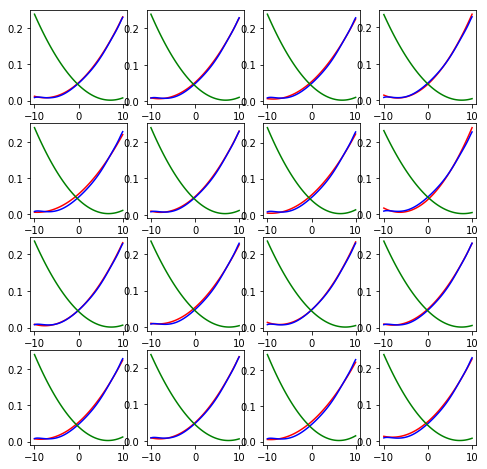

In [17]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y2[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y1[k],'g-')

In [ ]:
auto_test1 = create_model()
model2 = auto_test1.fit(np.atleast_3d(nor_y1), np.atleast_3d(nor_y2), epochs= 100, batch_size=2000)

Epoch 1/100
100000/100000 [==============================] - 2282s 23ms/step - loss: 0.0076
Epoch 2/100
 86000/100000 [========================>.....] - ETA: 5:19 - loss: 0.0039

In [77]:
model = load_model('auto_test')

In [78]:
model.save('auto_test_normal')

using the training data for testing

In [6]:
nor_y1_result = model.predict(np.atleast_3d(nor_y1))

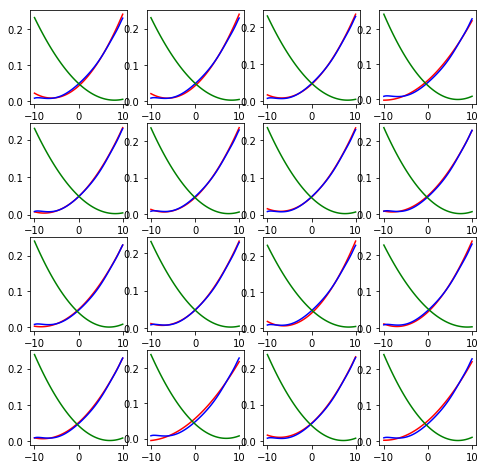

In [8]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y2[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y1[k],'g-')

change a,b,c,d,e,f medium value and varience value then test the changed data

In [68]:
x = np.linspace(-10,10,100)
y1 = []
y2 = []
a = []
b = []
c = []
d = []
e = []
f = []
z1 = np.random.uniform(0,12)
z2 = np.random.uniform(0,12)
z3 = np.random.uniform(0,12)
z4 = np.random.uniform(0,12)
z5 = np.random.uniform(0,12)
z6 = np.random.uniform(0,12)
z7 = np.random.uniform(0,12)
z8 = np.random.uniform(0,12)
z9 = np.random.uniform(0,12)
z10 = np.random.uniform(0,12)
z11 = np.random.uniform(0,12)
z12 = np.random.uniform(0,12)
    
for k in range(10000):
    a_ = np.random.normal(1, 7, 1)
    b_ = np.random.normal(3, 6, 1)
    c_ = np.random.normal(2, 5, 1)
    d_ = np.random.normal(4, 4, 1)
    e_ = np.random.normal(6, 3, 1)
    f_ = np.random.normal(5, 2, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_,e_,f_,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12)
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)
        
nor_y1 = preprocessing.normalize(y1)
nor_y2 = preprocessing.normalize(y2)

In [10]:
nor_y1_result = model.predict(np.atleast_3d(nor_y1))

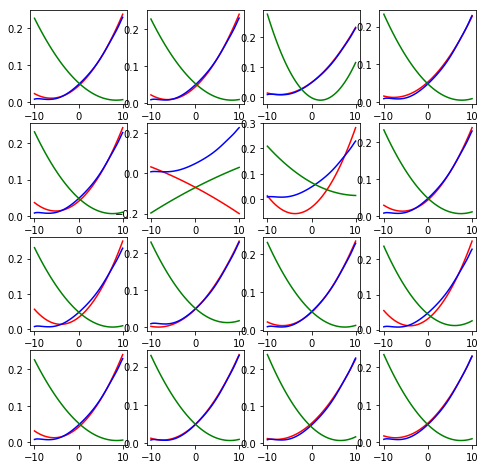

In [13]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y2[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y1[k],'g-')

change a,b,c,d,e,f to be uniform distribution then test the changed data

In [31]:
y3 = []
y4 = []
a = []
b = []
c = []
d = []
e = []
f = []
z1 = np.random.uniform(0,12)
z2 = np.random.uniform(0,12)
z3 = np.random.uniform(0,12)
z4 = np.random.uniform(0,12)
z5 = np.random.uniform(0,12)
z6 = np.random.uniform(0,12)
z7 = np.random.uniform(0,12)
z8 = np.random.uniform(0,12)
z9 = np.random.uniform(0,12)
z10 = np.random.uniform(0,12)
z11 = np.random.uniform(0,12)
z12 = np.random.uniform(0,12)
    
for k in range(10000):
    a_ = np.random.uniform(1, 7, 1)
    b_ = np.random.uniform(3, 6, 1)
    c_ = np.random.uniform(2, 5, 1)
    d_ = np.random.uniform(4, 8, 1)
    e_ = np.random.uniform(5, 9, 1)
    f_ = np.random.uniform(6, 12, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_,e_,f_,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12)
    y3.append(y1_)
    y4.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)
        
nor_y3 = preprocessing.normalize(y3)
nor_y4 = preprocessing.normalize(y4)

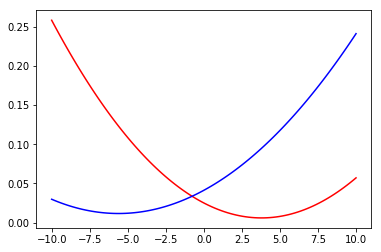

In [72]:
plt.plot(x,nor_y3[0],'r-')
plt.plot(x,nor_y4[0],'b-')

In [79]:
nor_y3_result = model.predict(np.atleast_3d(nor_y3))

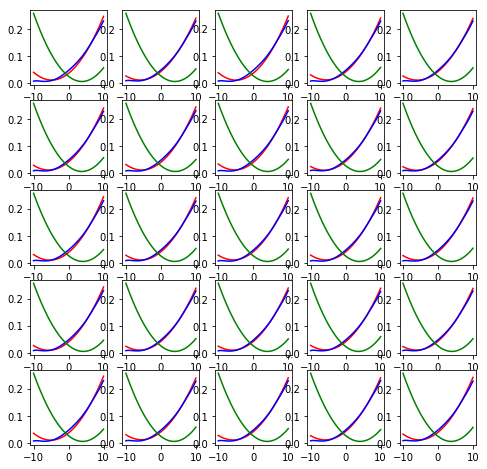

In [84]:
f_y3 = nor_y3
f_y4 = nor_y4
f_fit = nor_y3_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y3.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y4[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y3[k],'g-')

using normal model to train the uniform data

In [25]:
x = np.linspace(-10,10,100)
y5 = []
y6 = []
a = []
b = []
c = []
d = []
e = []
f = []
z1 = np.random.uniform(0,12)
z2 = np.random.uniform(0,12)
z3 = np.random.uniform(0,12)
z4 = np.random.uniform(0,12)
z5 = np.random.uniform(0,12)
z6 = np.random.uniform(0,12)
z7 = np.random.uniform(0,12)
z8 = np.random.uniform(0,12)
z9 = np.random.uniform(0,12)
z10 = np.random.uniform(0,12)
z11 = np.random.uniform(0,12)
z12 = np.random.uniform(0,12)
    
for k in range(10000):
    a_ = np.random.uniform(-10, 0, 1)
    b_ = np.random.uniform(0, 5, 1)
    c_ = np.random.uniform(5, 10, 1)
    d_ = np.random.uniform(-10, -5, 1)
    e_ = np.random.uniform(-5, 0, 1)
    f_ = np.random.uniform(0, 10, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_,e_,f_,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12)
    y5.append(y1_)
    y6.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)
        
nor_y5 = preprocessing.normalize(y5)
nor_y6 = preprocessing.normalize(y6)

In [59]:
x = np.linspace(-10, 10, 100)
y7 = []
y8 = []
a = []
b = []
c = []
d = []
e = []
f = []

z1 = np.random.uniform(0, 12)
z2 = np.random.uniform(0, 12)
z3 = np.random.uniform(0, 12)
z4 = np.random.uniform(0, 12)
z5 = np.random.uniform(0, 12)
z6 = np.random.uniform(0, 12)
z7 = np.random.uniform(0, 12)
z8 = np.random.uniform(0, 12)
z9 = np.random.uniform(0, 12)
z10 = np.random.uniform(0, 12)
z11 = np.random.uniform(0, 12)
z12 = np.random.uniform(0, 12)

for k in range(10000):
    a_ = np.random.uniform(-12, -8, 1)
    b_ = np.random.uniform(-8, -4, 1)
    c_ = np.random.uniform(-4, 0, 1)
    d_ = np.random.uniform(0,4, 1)
    e_ = np.random.uniform(4, 8, 1)
    f_ = np.random.uniform(8, 12, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_, e_, f_, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12)
    y7.append(y1_)
    y8.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)

nor_y7 = preprocessing.normalize(y7)
nor_y8 = preprocessing.normalize(y8)

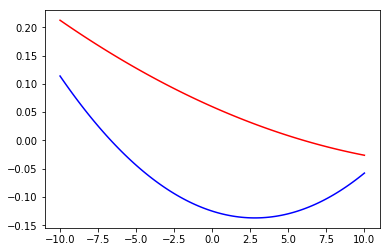

In [6]:
plt.plot(x,nor_y5[1],'r-')
plt.plot(x,nor_y6[1],'b-')

In [50]:
nor_y5_result = model.predict(np.atleast_3d(nor_y5))

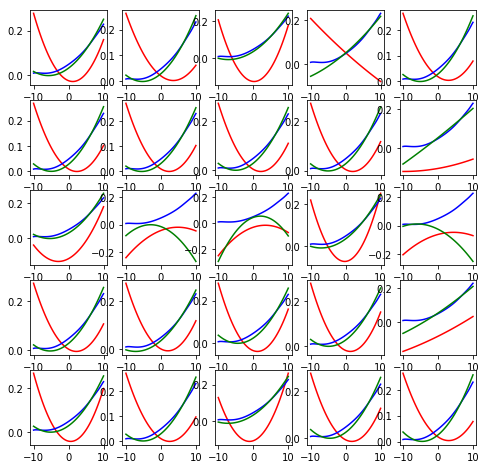

In [54]:
f_y5 = nor_y5
f_y6 = nor_y6
f_fit = nor_y5_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y5.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y5[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y6[k],'g-')

training a uniform model

In [ ]:
auto_test = create_model()
model1 = auto_test.fit(np.atleast_3d(nor_y5), np.atleast_3d(nor_y6), epochs= 100, batch_size=2000)

Epoch 1/100
 502000/1000000 [==============>...............] - ETA: 1:07:37 - loss: 0.0033

In [9]:
auto_test.save('auto_test_uniform_1m')


In [46]:
uniform  = load_model('uniform_new')

In [16]:
normal = load_model('auto_test_normal')

In [47]:
nor_y5_result = uniform.predict(np.atleast_3d(nor_y5))

In [51]:
nor_y3_result = uniform.predict(np.atleast_3d(nor_y3))

In [56]:
nor_y1_result = uniform.predict(np.atleast_3d(nor_y1))

train error using y7 ,y8 is 8.02e-4

In [60]:
nor_y7_result = uniform.predict(np.atleast_3d(nor_y7))

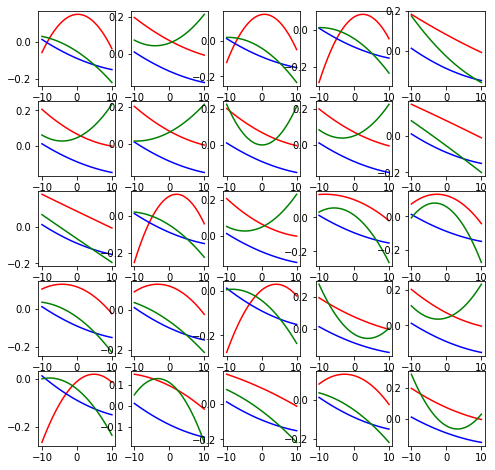

In [50]:
f_y5 = nor_y5
f_y6 = nor_y6
f_fit = nor_y5_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y5.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y5[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y6[k],'g-')

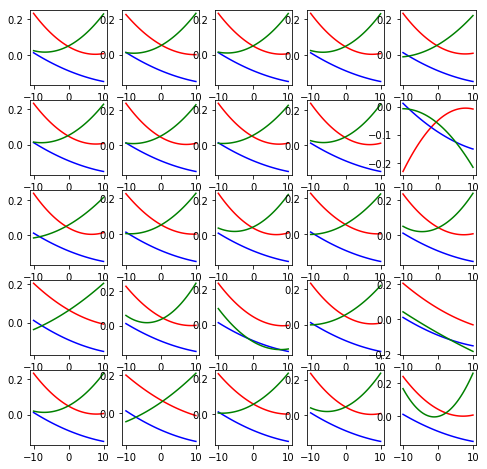

In [58]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y1[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y2[k],'g-')

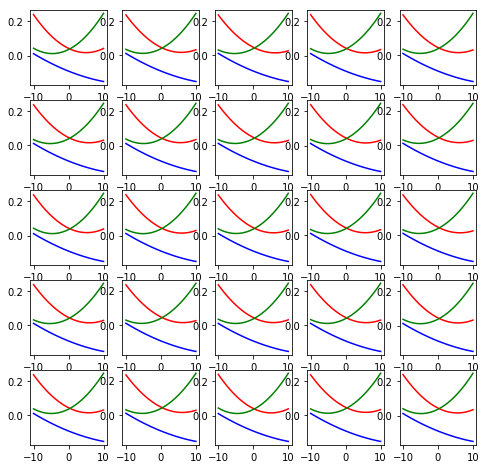

In [53]:
f_y3 = nor_y3
f_y4 = nor_y4
f_fit = nor_y3_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y3.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y3[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y4[k],'g-')

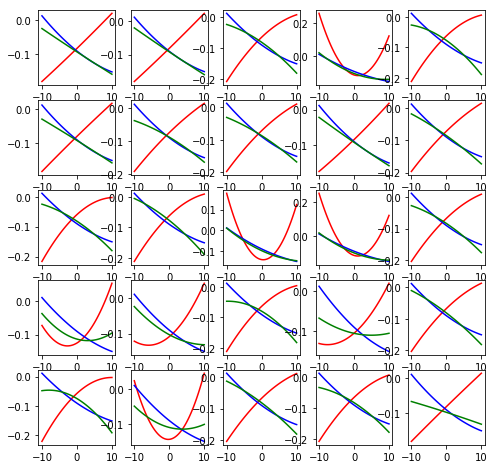

In [63]:
f_y7 = nor_y7
f_y8 = nor_y8
f_fit = nor_y7_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y7.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y7[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y8[k],'g-')

In [71]:
x = np.linspace(-10, 10, 100)
y5 = []
y6 = []
a = []
b = []
c = []
d = []
e = []
f = []

z1 = np.random.uniform(0, 12)
z2 = np.random.uniform(0, 12)
z3 = np.random.uniform(0, 12)
z4 = np.random.uniform(0, 12)
z5 = np.random.uniform(0, 12)
z6 = np.random.uniform(0, 12)
z7 = np.random.uniform(0, 12)
z8 = np.random.uniform(0, 12)
z9 = np.random.uniform(0, 12)
z10 = np.random.uniform(0, 12)
z11 = np.random.uniform(0, 12)
z12 = np.random.uniform(0, 12)

for k in range(10000):
    a_ = np.random.uniform(-10, -8, 1)
    b_ = np.random.uniform(-8, -6, 1)
    c_ = np.random.uniform(-6, -4, 1)
    d_ = np.random.uniform(-4,-2, 1)
    e_ = np.random.uniform(-2, 0, 1)
    f_ = np.random.uniform(0, 2, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_, e_, f_, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12)
    y5.append(y1_)
    y6.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)

nor_y5 = preprocessing.normalize(y5)
nor_y6 = preprocessing.normalize(y6)

In [65]:
new_2 = load_model('uniform_new_2')

In [66]:
nor_y5_result = new_2.predict(np.atleast_3d(nor_y5))

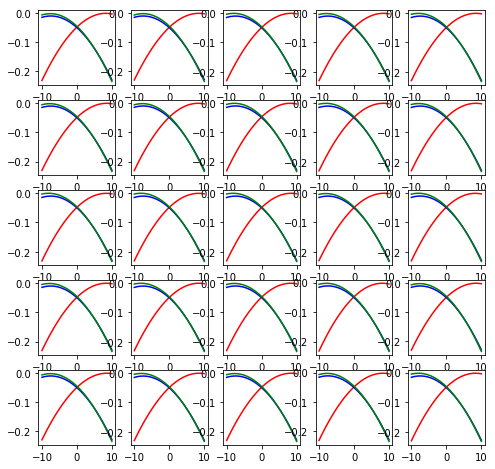

In [67]:
f_y5 = nor_y5
f_y6 = nor_y6
f_fit = nor_y5_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y5.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y5[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y6[k],'g-')

In [69]:
nor_y1_result = new_2.predict(np.atleast_3d(nor_y1))

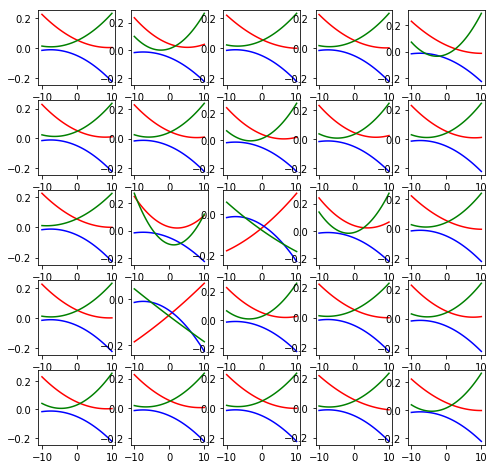

In [70]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y1[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y2[k],'g-')

In [73]:
score = new_2.evaluate(np.atleast_3d(nor_y5), np.atleast_3d(nor_y6))

10000/10000 [==============================] - 365s 37ms/step


In [75]:
score

8.910957996267825e-05

In [77]:
score_1 = new_2.evaluate(np.atleast_3d(nor_y1), np.atleast_3d(nor_y2))

10000/10000 [==============================] - 362s 36ms/step


In [78]:
score_1

0.03578345475196838

In [83]:
score_1 = new_2.evaluate(np.atleast_3d(nor_y1[0]), np.atleast_3d(nor_y2[0]),verbose = 0)

generate the parameter and loss error below

In [85]:
x = np.linspace(-10,10,100)
y1 = []
y2 = []
a = []
b = []
c = []
d = []
e = []
f = []
z1 = np.random.uniform(0,12)
z2 = np.random.uniform(0,12)
z3 = np.random.uniform(0,12)
z4 = np.random.uniform(0,12)
z5 = np.random.uniform(0,12)
z6 = np.random.uniform(0,12)
z7 = np.random.uniform(0,12)
z8 = np.random.uniform(0,12)
z9 = np.random.uniform(0,12)
z10 = np.random.uniform(0,12)
z11 = np.random.uniform(0,12)
z12 = np.random.uniform(0,12)
    
for k in range(100000):
    a_ = np.random.normal(1, 7, 1)
    b_ = np.random.normal(3, 6, 1)
    c_ = np.random.normal(2, 5, 1)
    d_ = np.random.normal(4, 4, 1)
    e_ = np.random.normal(6, 3, 1)
    f_ = np.random.normal(5, 2, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_,e_,f_,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12)
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)
        
nor_y1 = preprocessing.normalize(y1)
nor_y2 = preprocessing.normalize(y2)

In [86]:
model_normal = load_model('auto_test_normal')

In [91]:
error = []
for k in range (100000):
    error_ = model_normal.evaluate(np.atleast_3d(nor_y1[k]), np.atleast_3d(nor_y2[k]),verbose = 0)
    error.append(error_)

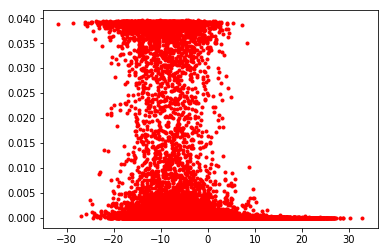

In [94]:
plt.plot(a,error,'r.')

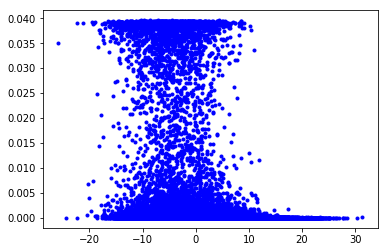

In [95]:
plt.plot(b,error,'b.')

[array([5.83629384]),
 array([-1.41842663]),
 array([0.44424106]),
 array([-2.66138891]),
 array([3.98318845]),
 array([6.0699938]),
 array([9.02024435]),
 array([4.07394136]),
 array([-3.75351329]),
 array([4.92189154]),
 array([-1.64769452]),
 array([7.91602909]),
 array([-0.51200347]),
 array([-0.80162812]),
 array([2.08279318]),
 array([5.96050216]),
 array([3.24358506]),
 array([-5.91177402]),
 array([-6.03562571]),
 array([-2.96247773]),
 array([3.86920996]),
 array([-2.49607742]),
 array([-10.30182496]),
 array([2.16363669]),
 array([2.35614705]),
 array([-0.32489834]),
 array([8.09478802]),
 array([7.29807234]),
 array([4.26591191]),
 array([2.31626917]),
 array([11.69554948]),
 array([3.87097495]),
 array([5.84349509]),
 array([-0.31851025]),
 array([11.99034824]),
 array([9.4093016]),
 array([0.12030314]),
 array([-0.0881708]),
 array([-9.9320833]),
 array([-3.06460188]),
 array([9.70875687]),
 array([-1.42437288]),
 array([-3.57919123]),
 array([2.80782046]),
 array([-10.918

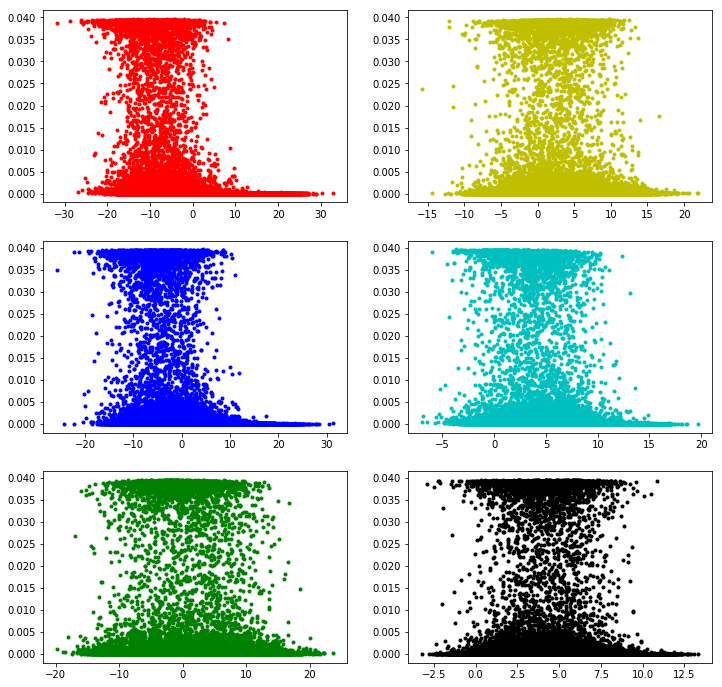

In [102]:
fig, axs = plt.subplots(ncols=2, nrows=3,figsize=(12,12))
axs[0,0].plot(a,error,'r.')
axs[1,0].plot(b,error,'b.')
axs[2,0].plot(c,error,'g.')
axs[0,1].plot(d,error,'y.')
axs[1,1].plot(e,error,'c.')
axs[2,1].plot(f,error,'k.')